# Welcome to the SAGAN fit tutorial

We are lucky, WFIRST give us a preview event of its work. 

As a general guideline for this tutorial, the lines inside :
###****CHANGE****####
###****ENDOFCHANGE****###
needs your inputs.

Let's have a look at your chosen lightcurve first.


In [1]:
## First import the required libraries
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import time

lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlcaustics
from pyLIMA import microltoolbox

import check

ImportError: No module named check

<IPython.core.display.Javascript object>


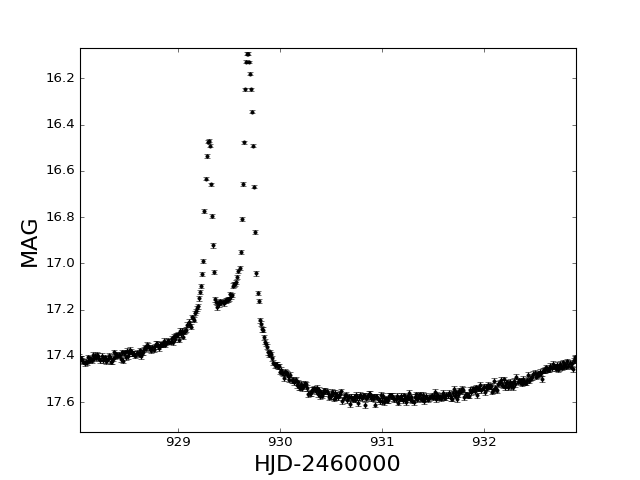

In [3]:
### Let's have a look at this event.

### You need to change the path below to the lightcurve you want to treat.
### Something like '/path_to_the_lightcurve/lightcurve_name'

###****CHANGE****###
filename = './WFIRST_binary_SAGAN.dat'
###****ENDOFCHANGE****###
WFIRST_data = np.loadtxt(filename)

### Lets have a look at what it is exactly :
figure1 = plt.figure()
plt.errorbar(WFIRST_data[:,0]-2460000,WFIRST_data[:,1],yerr = WFIRST_data[:,2],fmt='.k')
plt.xlabel('HJD-2460000',fontsize=20)
plt.ylabel('MAG',fontsize=20)
plt.gca().invert_yaxis()
figure1.show()


In [4]:
### First, let's find some properties of the anomaly.
### We need it for speed-up computations (see below) and also
### if you do not have parameters estimations from the theory session.

###****CHANGE****###
### time when the anomaly occurs
t_anomaly = 2460930

### duration of the anomaly.
delta_t = 4.0
###****ENDOFCHANGE****###


<IPython.core.display.Javascript object>


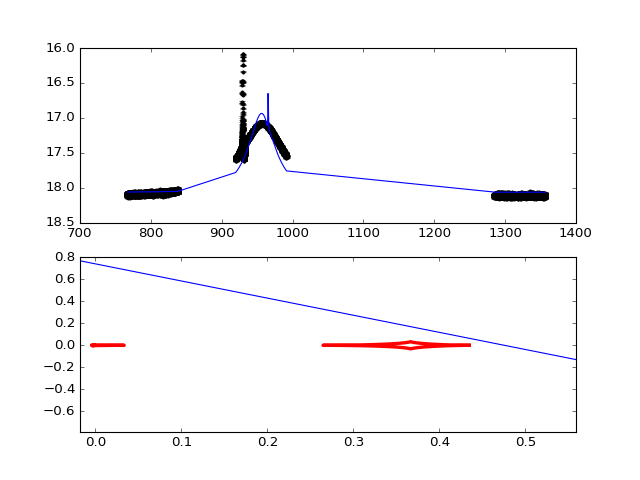

In [5]:
### Insert the parameters you estimated here:

###****CHANGE****###
to = 2460956.448
uo = 0.4
tE = 35.0
rho = 0.000464
s = 1.2
q = 1*10**-3
alpha = -1.0

log_s = np.log10(s)
log_q = np.log10(q)
###****ENDOFCHANGE****###

### Create an event object. You can choose the name :

your_event = event.Event()

###****CHANGE****###
your_event.name = 'WFIRST binary'

### We define a telescope object.
wfirst = telescopes.Telescope(name='WFIRST', camera_filter='W149', light_curve_magnitude=WFIRST_data)
###****ENDOFCHANGE****###


your_event.telescopes.append(wfirst)

### Let's define a binary model, name in pyLIMA is Uniform Source Binary Lens.

binary_model = microlmodels.create_model('USBL', your_event)
binary_model.define_model_parameters()

### Have a look at your guess. Change these parameters if you want 
estimate_parameters = [to, uo, tE, rho, np.log10(s), np.log10(q), alpha]

pyLIMA_parameters = binary_model.compute_pyLIMA_parameters(estimate_parameters)


model, wfirst_source_flux, wfirst_blend_flux = binary_model.compute_the_microlensing_model(wfirst, pyLIMA_parameters)
model_in_magnitude = microltoolbox.flux_to_magnitude(model)
regime, caustics, critical_curves = microlcaustics.find_2_lenses_caustics_and_critical_curves(10**pyLIMA_parameters.logs,
                                                                                         10** pyLIMA_parameters.logq,
                                                                                         resolution=5000)
reference_telescope = wfirst 
trajectory_x, trajectory_y = binary_model.source_trajectory(reference_telescope,
                                                                    pyLIMA_parameters.to,
                                                                    pyLIMA_parameters.uo,
                                                                    pyLIMA_parameters.tE,
                                                                    pyLIMA_parameters)        


plt.figure()
plt.subplot(211)
plt.errorbar(WFIRST_data[:,0]-2460000,WFIRST_data[:,1],yerr = WFIRST_data[:,2],fmt='.k')
plt.gca().invert_yaxis()
plt.plot(wfirst.lightcurve_flux[:,0]-2460000, model_in_magnitude)
plt.subplot(212)
for count, caustic in enumerate(caustics):
            try:
                plt.plot(caustic.real, caustic.imag,lw=3,c='r')
                plt.plot(critical_curves[count].real, critical_curves[count].imag, '--k')
            except AttributeError:
                pass
plt.plot(trajectory_x, trajectory_y)
plt.show()
### Now you can modify the estimated parameters to see if you can obtain a better fit.
###
### We recommend changing only one parameter at a time and possibly keeping notes.
### 0. Is there a planetary anomaly? No? Try changing alpha by +/-180. degrees and/or changing the sign of alpha.
### 1. Is the peak time correct? No? Try changing to.
### 2. Is the overall model lightcurve too wide/narrow? Try decreasing/increasing tE.
### 3. Is the overall model lightcurve too tall/short? Try decreasing/increasing uo.
### 4. Is the planetary perturbation too big/small? Try decreasing/increasing q.
### 5. Is the planetary perturbation at the wrong time? Try changing s and alpha 
###    (these need to be changed together; changing s will move the caustic away from the source trajectory, 
###    so you will have to rotate the binary axis so the source still crosses it)
### 6. Does rho look correct? Increasing rho will smooth out the planetary perturbation and decreasing 
###    rho will make it pointier.



# Suggested change factor:
#to : +/- 0.1
#uo :  * [0.95,1.05]
#tE : +/- 1
#rho : * [0.95,1.05]
#log_s : * [0.95,1.05]
#log_q : * [0.95,1.05]
#alpha : +/- 0.1


Start fit on WFIRST binary, with model PSPL and method LM
check_event  : Everything looks fine, this event can be fitted
initial_guess  : Initial parameters guess SUCCESS
lmarquardt  : Levenberg_marquardt fit SUCCESS
[2460956.853308085, 0.4235797108967089, 60.14808984201651, 5443.201770739473, -0.04720545959255119, 20176.592710352452]


<IPython.core.display.Javascript object>


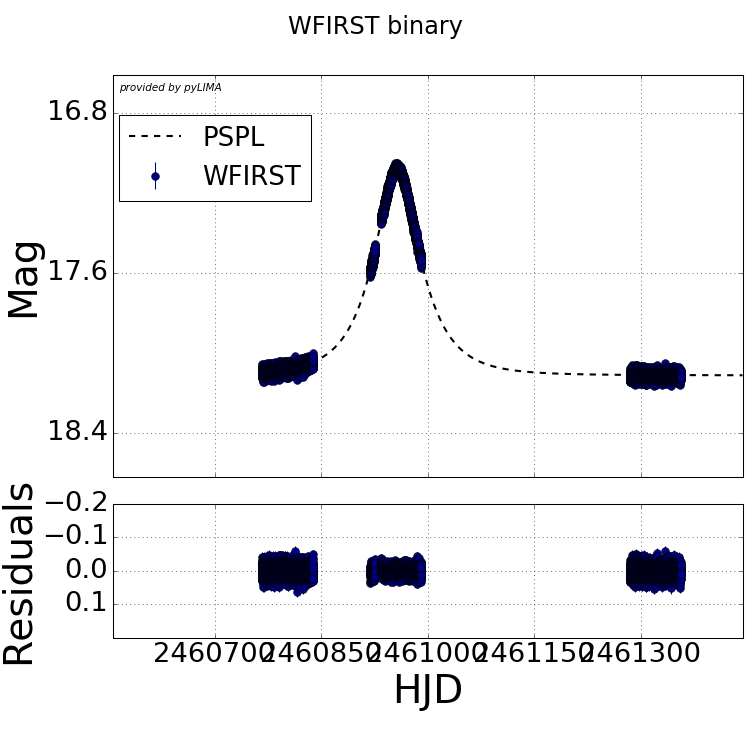

<IPython.core.display.Javascript object>


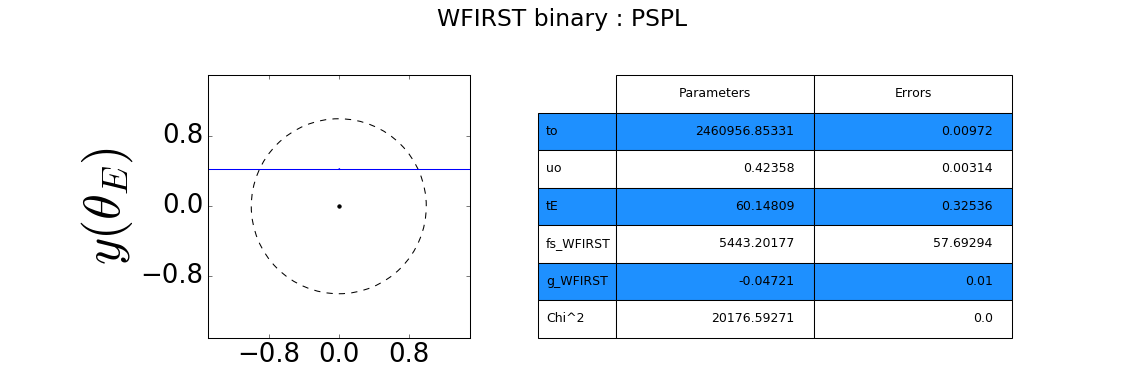

In [6]:
### Let's fit with a Point Source Point Lens model

### We delete the anomaly for this first fit
good = np.where((WFIRST_data[:,0]<t_anomaly-delta_t) | 
                (WFIRST_data[:,0]>t_anomaly+delta_t))[0]


WFIRST_data_reduce = WFIRST_data[good]

### Plot reject/accept data


wfirst = telescopes.Telescope(name='WFIRST', camera_filter='W149', light_curve_magnitude=WFIRST_data_reduce)

your_event.telescopes[0] = wfirst

pspl_model = microlmodels.create_model('PSPL', your_event)

### We fit the event using a Levenberg-Marquardt ('LM' thereafter) method.
your_event.fit(pspl_model,'LM')
your_event.fits[0].produce_outputs()
plt.show()


### How do the fit parameters for to, uo, tE compare to your estimates?

In [7]:
### Extract PSPL parameters from first fit 

to = your_event.fits[0].outputs.fit_parameters.to
uo = your_event.fits[0].outputs.fit_parameters.uo
tE = your_event.fits[0].outputs.fit_parameters.tE


In [8]:
### we redefine our event for the final fit. 
your_event = event.Event()
your_event.name = 'WFIRST binary'


### Speed up computations

### Calculating the finite-source binary magnification is computationally intensive. 
### Except at the time of the planetary anomaly, a faster approximation can be used. 
### The line below limits use of the full calculation to a short window around the anomaly.


### It takes a long time to generate a model for 40,000 data points. Except during the planetary anomaly, 
### the additional points do not add significant information, so we will get the same results if we use only
### 1 of N data points. In the example below, we thin the light curve to 1/32 points outside of the planetary 
### anomaly and 1/8 points during the anomaly.You can change it, but this is CASE SENSITIVE!!!

### Over the anomaly, there should be at least 4 points over a caustic entrance/exit in order to accurately 
### measure rho. Therefore, a good number of to use instead of "8" (the thinning over the anomaly) is 
### 2*int(delta_t/2+1) where dt is the duration of the caustic entrance (note dt is approximately equal to 2*t_*, 
### which is twice the source radius crossing time).

###****CHANGE****### NOT MANDATORY!!
binary_model.USBL_windows = [t_anomaly-2*delta_t,t_anomaly+2*delta_t]
###****ENDOFCHANGE****###




start_anomaly = np.where(WFIRST_data[:,0]<binary_model.USBL_windows[0])[0][-1]
end_anomaly = np.where(WFIRST_data[:,0]>binary_model.USBL_windows[1])[0][0]


### You can here change the number of points you select(anomaly_step_size) around the anomaly for the final fit. 
###. If your first fit did not work at first try, this could be due to this.

###****CHANGE****### NOT MANDATORY!!

anomaly_step_size =  2*int(delta_t/2+1) 

light_curve_reduce = np.r_[WFIRST_data[:start_anomaly:32],
                           WFIRST_data[start_anomaly:end_anomaly:anomaly_step_size],
                           WFIRST_data[end_anomaly::32]]

###****ENDOFCHANGE****###

wfirst = telescopes.Telescope(name='WFIRST', camera_filter='W149', light_curve_magnitude=light_curve_reduce)

your_event.telescopes.append(wfirst)



### to boundaries
binary_model.parameters_boundaries[0] = [to-0.5,to+0.5]
### uo boundaries
binary_model.parameters_boundaries[1] = [uo*0.99 , uo*1.01]
### tE boundaries
binary_model.parameters_boundaries[2] = [tE-0.5,tE+0.5]
### rho boundaries
binary_model.parameters_boundaries[3] = [10**-4,10**-2]
### log_10(s) boundaries
binary_model.parameters_boundaries[4] = [np.log10(s)-0.05,np.log10(s)+0.05]
### log_10(q) boundaries, no need to change this
#binary_model.parameters_boundaries[5] = [-5.60,-3.60]
### alpha boundaries
binary_model.parameters_boundaries[6] = [alpha-1.0,alpha+1.0]

### check your parameters boundaries!
check.check_parameter_boundaries(binary_model.parameters_boundaries, filename)
    
    
### Differential Evolution ('DE' thereafter) will be used for the next fit.DE_population_size scale the size of the DE population. More it is, bigger is your chance to find the minima
### but slower it is. We set it to 4, but this may not converge. This is CASE SENSITIVE.
start = time.time()

###****CHANGE****### NOT MANDATORY!!
your_event.fit(binary_model, 'DE',  DE_population_size = 4)
###****ENDOFCHANGE****###

print('Runtime {0} seconds'.format(time.time()-start))
your_event.fits[-1].produce_outputs()
plt.show()

### How do the final fit parameters compare to your estimates?

NameError: name 'check' is not defined